<a href="https://colab.research.google.com/github/AliciaFalconCaro/PythonColabExamples/blob/main/RegressorsForHousePricePrediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In this example, we will use 3 regressors for the prediction of house prices.
We obtained the dataset from: https://docs.google.com/spreadsheets/d/1caaR9pT24GNmq3rDQpMiIMJrmiTGarbs/edit?gid=1150341366#gid=1150341366

The 3 regressors are:
- SVM
- Random Forest
- Linear Regressor

This code is based on the tutorial provided in: https://www.geeksforgeeks.org/house-price-prediction-using-machine-learning-in-python/



In [1]:
#we start importing the dataset
import pandas

dataset = pandas.read_excel("HousePricePrediction.xlsx")

# Printing first 5 records of the dataset for a preview of the dataset
print(dataset.head(5))

#we check the shape/size/dimension of the dataset. In this case: (2919,13), so 13 features and 2919 observations.
dataset.shape


   Id  MSSubClass MSZoning  LotArea LotConfig BldgType  OverallCond  \
0   0          60       RL     8450    Inside     1Fam            5   
1   1          20       RL     9600       FR2     1Fam            8   
2   2          60       RL    11250    Inside     1Fam            5   
3   3          70       RL     9550    Corner     1Fam            5   
4   4          60       RL    14260       FR2     1Fam            5   

   YearBuilt  YearRemodAdd Exterior1st  BsmtFinSF2  TotalBsmtSF  SalePrice  
0       2003          2003     VinylSd         0.0        856.0   208500.0  
1       1976          1976     MetalSd         0.0       1262.0   181500.0  
2       2001          2002     VinylSd         0.0        920.0   223500.0  
3       1915          1970     Wd Sdng         0.0        756.0   140000.0  
4       2000          2000     VinylSd         0.0       1145.0   250000.0  


(2919, 13)

In [4]:
#Data preprocessing

#First, we find out the datatype and number of each feature
obj = (dataset.dtypes == 'object')
object_cols = list(obj[obj].index)
print("Categorical variables:",len(object_cols))


int_ = (dataset.dtypes == 'int')
num_cols = list(int_[int_].index)
print("Integer variables:",len(num_cols))

fl = (dataset.dtypes == 'float')
fl_cols = list(fl[fl].index)
print("Float variables:",len(fl_cols))

print("Categorical Variables names:", object_cols)

Categorical variables: 4
Integer variables: 6
Float variables: 3
Categorical Variables names: ['MSZoning', 'LotConfig', 'BldgType', 'Exterior1st']


<Axes: >

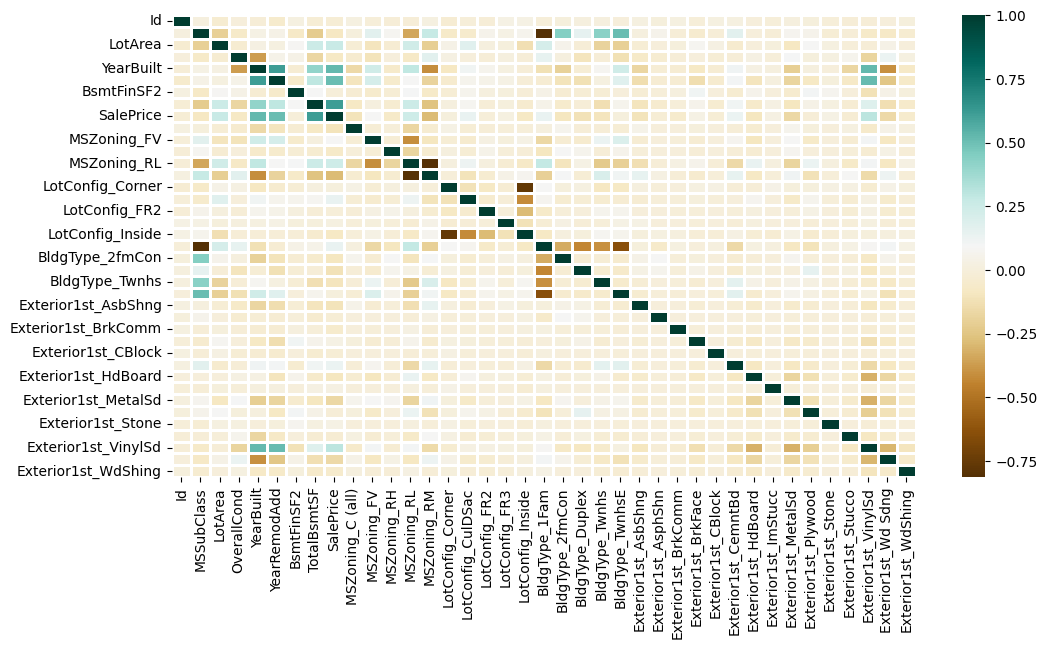

In [7]:
#Now we try to find any correlation between the features through a heatmap
import matplotlib.pyplot as matplot
import seaborn as sb

# Convert categorical features to numerical using one-hot encoding
dataset_encoded = pandas.get_dummies(dataset, columns=object_cols)

matplot.figure(figsize=(12, 6))
sb.heatmap(dataset_encoded.corr(), cmap = 'BrBG', fmt = '.2f', linewidths = 2, annot = False)

#The correlation is obtained between -1<x<1. Therefore:
  #positive values represent positive correlation (increase->increase)
  #negative values represent inverse correlation (increase->decrease)
  #values near 0 represent neutral (no correlation)


<Axes: title={'center': 'No. Unique values of Categorical Features'}>

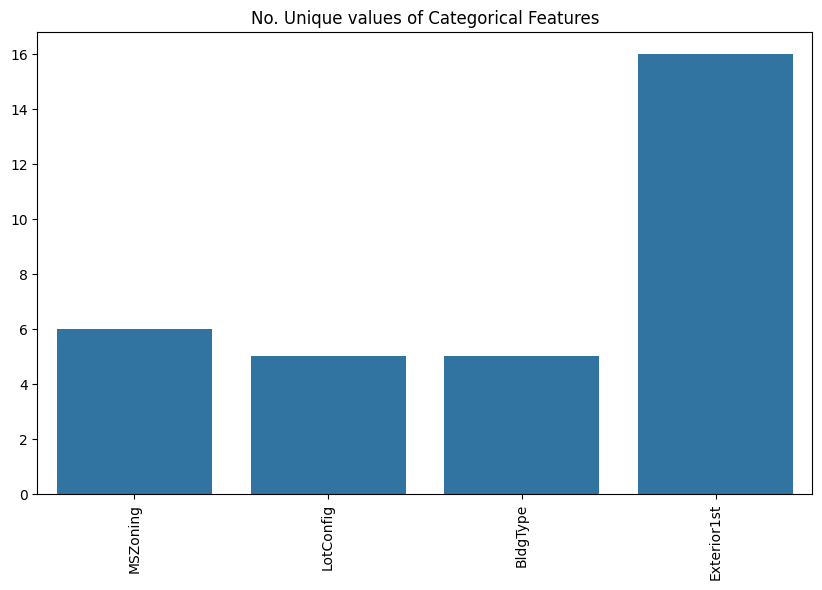

In [8]:
#we can also use a barplot to represent the features
import matplotlib.pyplot as matplot
import seaborn as sb

unique_values = []
for col in object_cols:
  unique_values.append(dataset[col].unique().size)
matplot.figure(figsize=(10,6))
matplot.title('No. Unique values of Categorical Features')
matplot.xticks(rotation=90) #rotate the names on the x-axis for easier reading
sb.barplot(x=object_cols,y=unique_values)


Categorical Features: Distribution


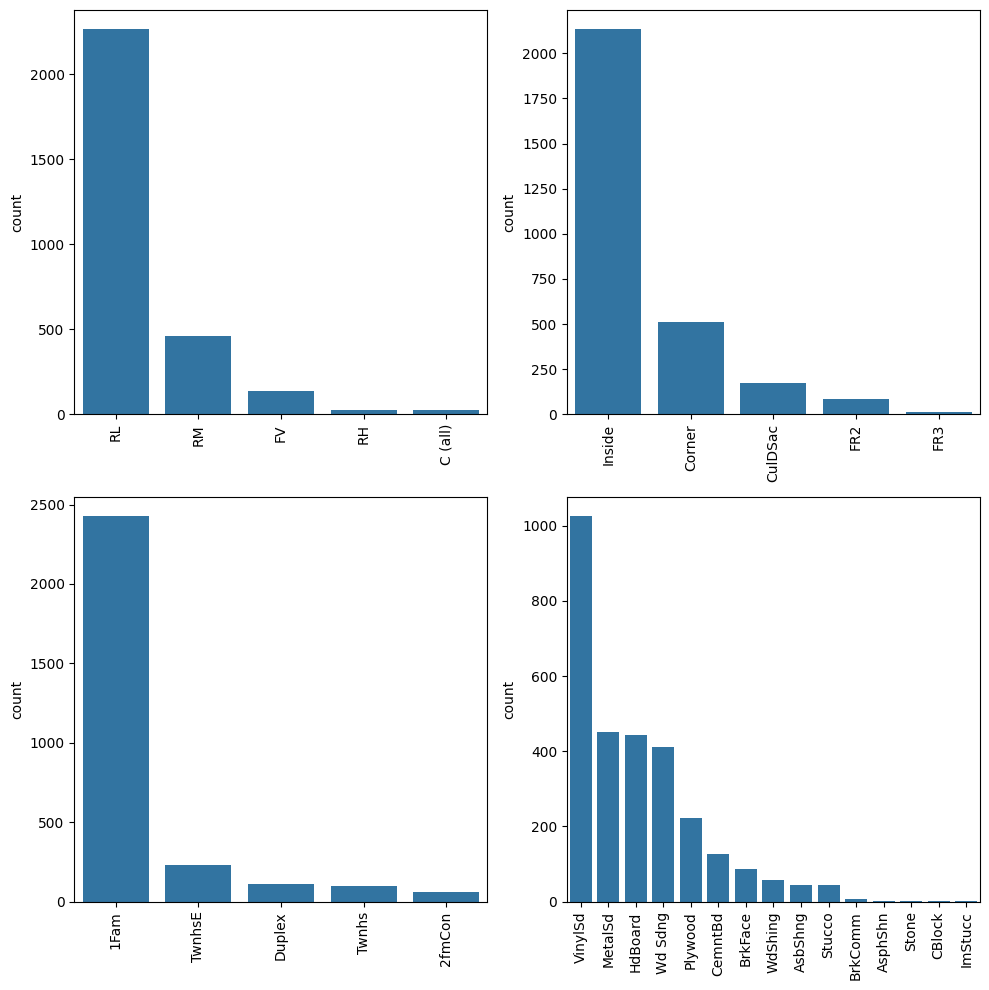

In [17]:
#To find out the actual count of each category we can plot the bargraph of each four features separately.

print('Categorical Features: Distribution')
index = 1

# Row and columns for subplots. This will improve the visualization
n_cols = 2
n_rows = 2

# Adjust figure size
matplot.figure(figsize=(10, 10))


for col in object_cols:
	y = dataset[col].value_counts()
	matplot.subplot(n_cols, n_rows, index)
	matplot.xticks(rotation=90)
	sb.barplot(x=list(y.index), y=y)
	index +=1

# Adjust layout to prevent overlap
matplot.tight_layout()
matplot.show()


In [18]:
#The next step will be Data Cleaning
#we remove any unnecessary (non-important) feature, such as ID

dataset.drop(['Id'],axis=1,inplace=True)

#for relevant/important features with null or empty values, since we cannot remove the whole feature, we can replace the empty values.
#for example, with SalePrice, we will substitute the empty values for the mean values to make the data distribution symmetric.

dataset['SalePrice'] = dataset['SalePrice'].fillna(dataset['SalePrice'].mean())

#Now, we can check how many null values are still in the dataset
dataset.isnull().sum()


,0
MSSubClass,0
MSZoning,4
LotArea,0
LotConfig,0
BldgType,0
OverallCond,0
YearBuilt,0
YearRemodAdd,0
Exterior1st,1
BsmtFinSF2,1


In [19]:
#Since there are no many null values anymore, we can just drop the records (or observations) with null or empty values
new_dataset = dataset.dropna()
#this allow us to remove all null values from the dataset before training
new_dataset.isnull().sum()

,0
MSSubClass,0
MSZoning,0
LotArea,0
LotConfig,0
BldgType,0
OverallCond,0
YearBuilt,0
YearRemodAdd,0
Exterior1st,0
BsmtFinSF2,0


In [20]:
#Now, we need to modify any Categorical features into values that can be used for training (as we did before when generating the correlation matrix).
#One way is through the use of "OneHotEncoder", which allows us to change categorical values to binary combinations, which can be represented as int.
from sklearn.preprocessing import OneHotEncoder

#First, we collect all the categorical features:
s = (new_dataset.dtypes == 'object')
object_cols = list(s[s].index)
print("Categorical variables:")
print(object_cols)
print('No. of. categorical features: ',
	len(object_cols))


Categorical variables:
['MSZoning', 'LotConfig', 'BldgType', 'Exterior1st']
No. of. categorical features:  4


In [21]:
#Now we apply OneHotEncoder to all the categorical features (stored in the objects_cols list)

OH_encoder = OneHotEncoder(sparse_output=False)
OH_cols = pandas.DataFrame(OH_encoder.fit_transform(new_dataset[object_cols]))
OH_cols.index = new_dataset.index
OH_cols.columns = OH_encoder.get_feature_names_out()
df_final = new_dataset.drop(object_cols, axis=1) #remove categorical features
df_final = pandas.concat([df_final, OH_cols], axis=1) #add transformed categorical features



In [22]:
#Now we prepare the data for training.
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split

X = df_final.drop(['SalePrice'], axis=1) #we remove SalePrice from observations to use it as labels since it is the feature to be predicted
Y = df_final['SalePrice'] #we set SalePrice as the labels column

# Split the data into training and testing set (training:0.8, testing:0.2)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size=0.8, random_state=0) #in this case, there is no need to shuffle the data before the split


In [23]:
#Now we train our model with SVM and show the mean absolute percentage error
from sklearn import svm
from sklearn.svm import SVC
from sklearn.metrics import mean_absolute_percentage_error

model_SVR = svm.SVR()
model_SVR.fit(X_train,Y_train)

Y_pred = model_SVR.predict(X_test)

print(mean_absolute_percentage_error(Y_test, Y_pred))


0.1870512931870423


In [24]:
#Now we try Random Forest
from sklearn.ensemble import RandomForestRegressor

model_RFR = RandomForestRegressor(n_estimators=10)
model_RFR.fit(X_train, Y_train)
Y_pred = model_RFR.predict(X_test)

mean_absolute_percentage_error(Y_test, Y_pred)


0.18369708886383734

In [25]:
#Finally, we try Linear Regression
from sklearn.linear_model import LinearRegression

model_LR = LinearRegression()
model_LR.fit(X_train, Y_train)
Y_pred = model_LR.predict(X_test)

print(mean_absolute_percentage_error(Y_test, Y_pred))


0.18741683841599918
